<a href="https://colab.research.google.com/github/guidenis93/A-Student-Guide-to-Bayesian-Statistics/blob/main/Problem_set_18.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Bayesian Multilevel Modeling Using Pystan

In [ ]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pystan 
import arviz as az
import random

## Data Cleaning

In [ ]:
# Import radon data
url = "https://raw.githubusercontent.com/pymc-devs/pymc-examples/main/examples/data/radon.csv"
df = pd.read_csv(url, sep = ",")

df.head(10)

,Unnamed: 0,idnum,state,state2,stfips,zip,region,typebldg,floor,room,basement,windoor,rep,stratum,wave,starttm,stoptm,startdt,stopdt,activity,pcterr,adjwt,dupflag,zipflag,cntyfips,county,fips,Uppm,county_code,log_radon
0,0,5081.0,MN,MN,27.0,55735,5.0,1.0,1.0,3.0,N,,2,4.0,41,930.0,930.0,12088.0,12288.0,2.2,9.7,1146.499190,1.0,0.0,1.0,AITKIN,27001.0,0.502054,0,0.832909
1,1,5082.0,MN,MN,27.0,55748,5.0,1.0,0.0,4.0,Y,,5,2.0,40,1615.0,1615.0,11888.0,12088.0,2.2,14.5,471.366223,0.0,0.0,1.0,AITKIN,27001.0,0.502054,0,0.832909
2,2,5083.0,MN,MN,27.0,55748,5.0,1.0,0.0,4.0,Y,,3,2.0,42,1030.0,1515.0,20288.0,21188.0,2.9,9.6,433.316718,0.0,0.0,1.0,AITKIN,27001.0,0.502054,0,1.098612
3,3,5084.0,MN,MN,27.0,56469,5.0,1.0,0.0,4.0,Y,,2,2.0,24,1410.0,1410.0,122987.0,123187.0,1.0,24.3,461.623670,0.0,0.0,1.0,AITKIN,27001.0,0.502054,0,0.095310
4,4,5085.0,MN,MN,27.0,55011,3.0,1.0,0.0,4.0,Y,,3,2.0,40,600.0,600.0,12888.0,13088.0,3.1,13.8,433.316718,0.0,0.0,3.0,ANOKA,27003.0,0.428565,1,1.163151
5,5,5086.0,MN,MN,27.0,55014,3.0,1.0,0.0,4.0,Y,,5,2.0,22,900.0,1300.0,120287.0,121187.0,2.5,12.8,471.366223,0.0,0.0,3.0,ANOKA,27003.0,0.428565,1,0.955511
6,6,5087.0,MN,MN,27.0,55014,3.0,1.0,0.0,4.0,Y,,5,2.0,28,2000.0,2025.0,121887.0,122087.0,1.5,14.5,471.366223,0.0,0.0,3.0,ANOKA,27003.0,0.428565,1,0.470004
7,7,5088.0,MN,MN,27.0,55014,3.0,1.0,0.0,2.0,Y,,3,2.0,33,800.0,1000.0,122587.0,122787.0,1.0,18.0,433.316718,0.0,0.0,3.0,ANOKA,27003.0,0.428565,1,0.095310
8,8,5089.0,MN,MN,27.0,55014,3.0,1.0,0.0,4.0,Y,,3,2.0,36,1000.0,1730.0,10188.0,10188.0,0.7,25.1,433.316718,0.0,0.0,3.0,ANOKA,27003.0,0.428565,1,-0.223144
9,9,5090.0,MN,MN,27.0,55014,3.0,1.0,0.0,4.0,Y,,2,2.0,44,900.0,900.0,20288.0,20288.0,1.2,17.5,461.623670,0.0,0.0,3.0,ANOKA,27003.0,0.428565,1,0.262364


In [ ]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 919 entries, 0 to 918
Data columns (total 30 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Unnamed: 0   919 non-null    int64  
 1   idnum        919 non-null    float64
 2   state        919 non-null    object 
 3   state2       919 non-null    object 
 4   stfips       919 non-null    float64
 5   zip          919 non-null    int64  
 6   region       919 non-null    float64
 7   typebldg     919 non-null    float64
 8   floor        919 non-null    float64
 9   room         919 non-null    float64
 10  basement     919 non-null    object 
 11  windoor      919 non-null    object 
 12  rep          919 non-null    int64  
 13  stratum      919 non-null    float64
 14  wave         919 non-null    int64  
 15  starttm      919 non-null    float64
 16  stoptm       919 non-null    float64
 17  startdt      919 non-null    float64
 18  stopdt       919 non-null    float64
 19  activity

In [ ]:
# Drop columns
drop_cols = ["Unnamed: 0", "state", "state2", "windoor"]
df.drop(labels = drop_cols, axis = 1, inplace = True)

# Change values 
df.loc[df["basement"] == "Y", "basement"] = 1
df.loc[df["basement"] == "N", "basement"] = 0

# Replace missing values (" ") by nan
df.where(df != " ", inplace = True)

# Missing values
print(df.isnull().sum())

# Drop basement missing values
df.dropna(subset = ["basement"], inplace = True)
df.reset_index(inplace = True)

# Adjusting county_code column
df["county_code"] = df["county_code"] + 1

INFO:numexpr.utils:NumExpr defaulting to 2 threads.


idnum           0
stfips          0
zip             0
region          0
typebldg        0
floor           0
room            0
basement       41
rep             0
stratum         0
wave            0
starttm         0
stoptm          0
startdt         0
stopdt          0
activity        0
pcterr          0
adjwt           0
dupflag         0
zipflag         0
cntyfips        0
county          0
fips            0
Uppm            0
county_code     0
log_radon       0
dtype: int64


## Data Visualization

### Distribution of log radon by county

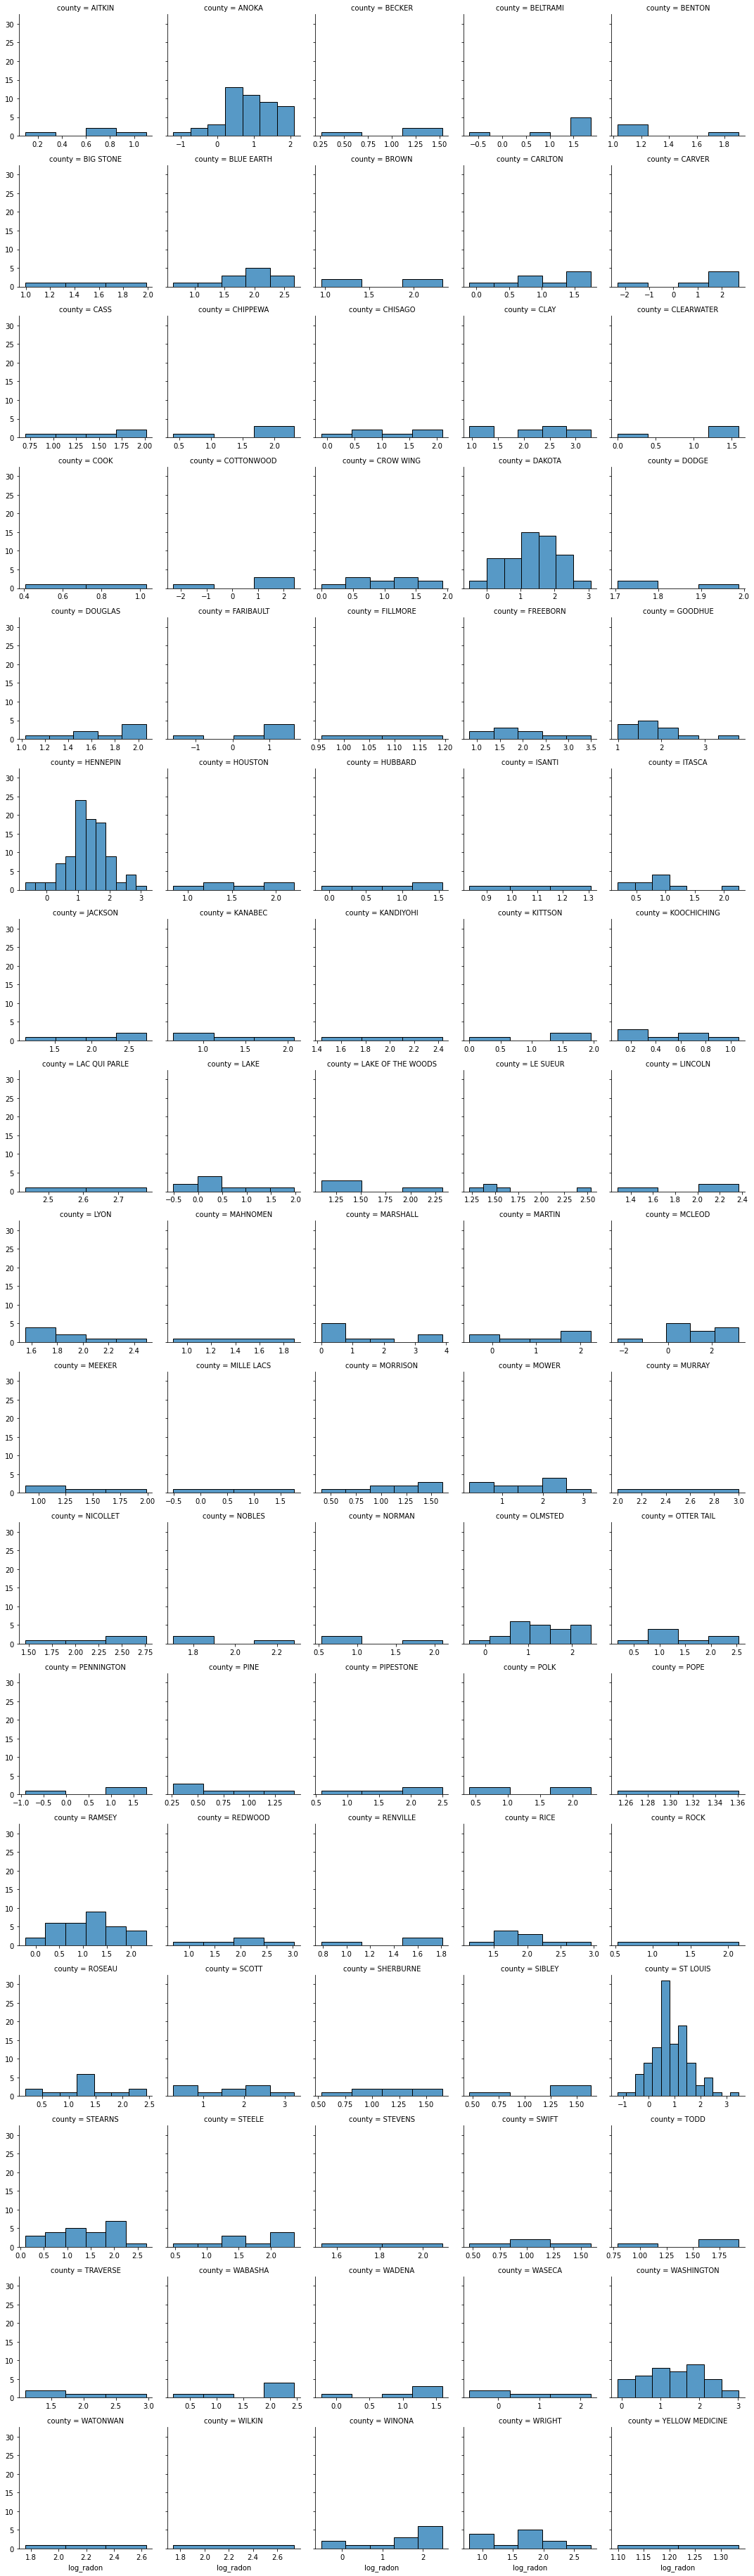

In [ ]:
g = sns.FacetGrid(df, col = "county", col_wrap=5, sharex = False, sharey = True)
g.map(sns.histplot, "log_radon")

### Pair Grid with features

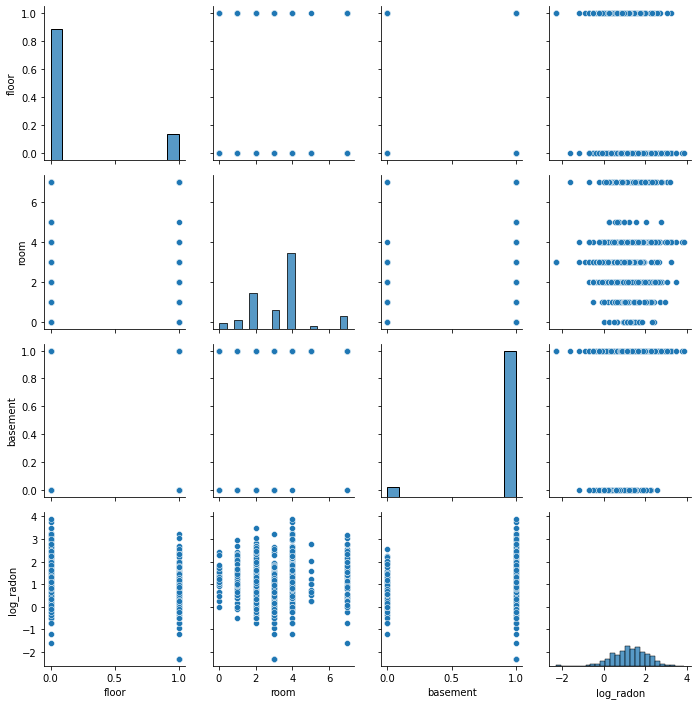

In [ ]:
pair_col = ["floor", "room", "basement", "log_radon"]

g = sns.PairGrid(df[pair_col])
g.map_diag(sns.histplot)
g.map_offdiag(sns.scatterplot)

## Bayesian Regressions

### Pooled model

In [ ]:
pooled_model = """

data {
  int <lower=0> N;
  vector[N] x;
  vector[N] y;
} 

parameters {
  real alpha;
  real beta;
  real <lower=0> sigma;
}

model {
  sigma ~ cauchy(0,1); //prior on sigma

  y ~ normal(alpha + beta * x, sigma); //likehood
}
"""

In [ ]:
# Data
N = df.shape[0]
x = list(df["basement"])
y = list(df["log_radon"])

data = {"N": N, "x" : x, "y" : y}

# Stan model
sm = pystan.StanModel(model_code = pooled_model)
fit = sm.sampling(data = data, iter=1000, chains=4, seed=1)
df_fit = fit.to_dataframe()

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_4f794b7dbd39e63cc97b31c0325817c0 NOW.


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fe2ebeb1e50>,
      dtype=object)

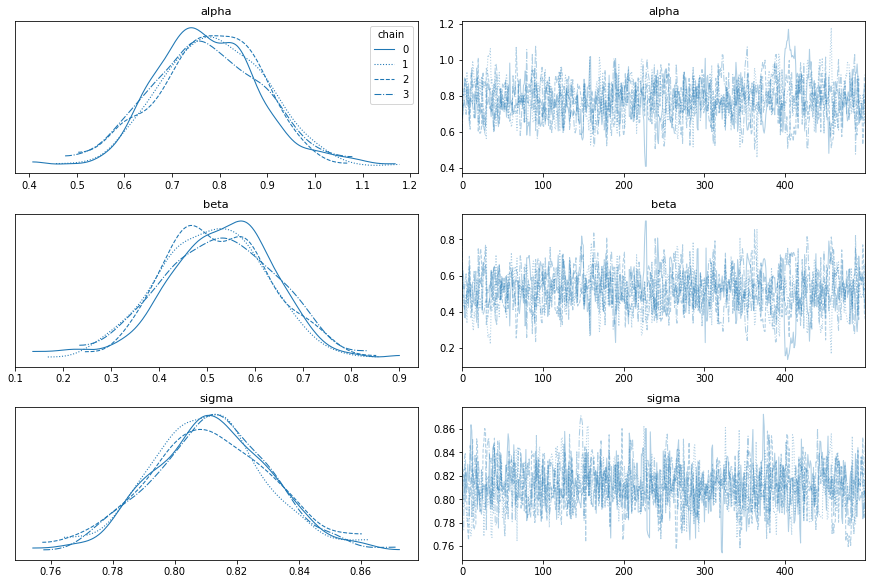

In [ ]:
# Posterior distributions and trace plots
az.plot_trace(fit, legend = True, figsize=(12,8))


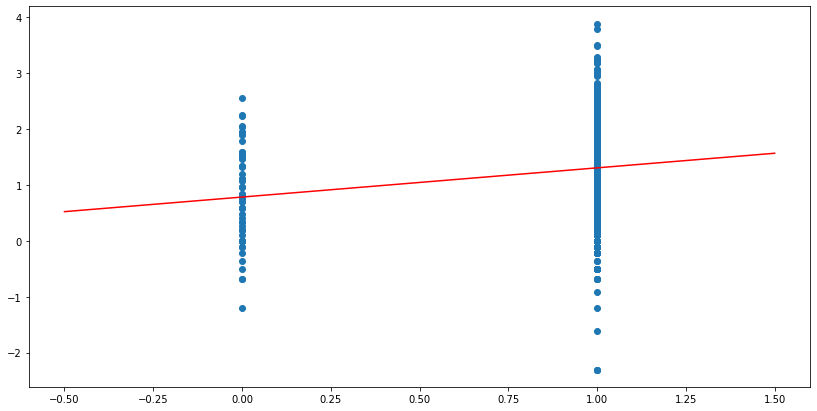

In [ ]:
# Plot regression line
min_x = min(x)
max_x = max(x)
x_gen = np.linspace(min_x - 0.5, max_x +0.5, num = 100)

alpha = df_fit["alpha"].mean()
beta = df_fit["beta"].mean()

y_hat = alpha + beta * x_gen

plt.figure(figsize=(14,7))
plt.plot(x_gen, y_hat, color = "red")
plt.scatter(x, y)

## Hierarchical Model

In [ ]:
het_model = """
data {
  int<lower=0> N;
  int<lower=0> J;
  vector[N] y;
  vector[N] x;
  int county[N];
}

parameters {
  real<lower=0> sigma;
  real<lower=0> sigma_a;
  real<lower=0> sigma_b;

  vector[J] a;
  vector[J] b;
  real mu_a;
  real mu_b;
}

model {
  //hyper-prios
  mu_a ~ normal(0, 100);
  mu_b ~ normal(0, 100);
  sigma_a ~ cauchy(0,1);
  sigma_b ~ cauchy(0,1);

  // priors
  a ~ normal(mu_a, sigma_a);
  b ~ normal(mu_b, sigma_b);

  //likehood
  for (i in 1:N){
    y[i] ~ normal(a[county[i]] + b[county[i]] * x[i], sigma);
  }
}
"""

In [ ]:
# Data
N = df.shape[0]
J = len(df["county"].unique())
county = list(df["county_code"])
x = list(df["basement"])
y = list(df["log_radon"])

data2 = {"N": N, "J": J, "y" : y, "x" : x, "county" : county}

In [ ]:
# Stan model
sm2 = pystan.StanModel(model_code = het_model)
fit2 = sm2.sampling(data = data2, iter=1000, chains=4, seed=1)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_93e5ff9c15758939e44ca272ec6a3469 NOW.


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fe2e1a58250>,
      dtype=object)

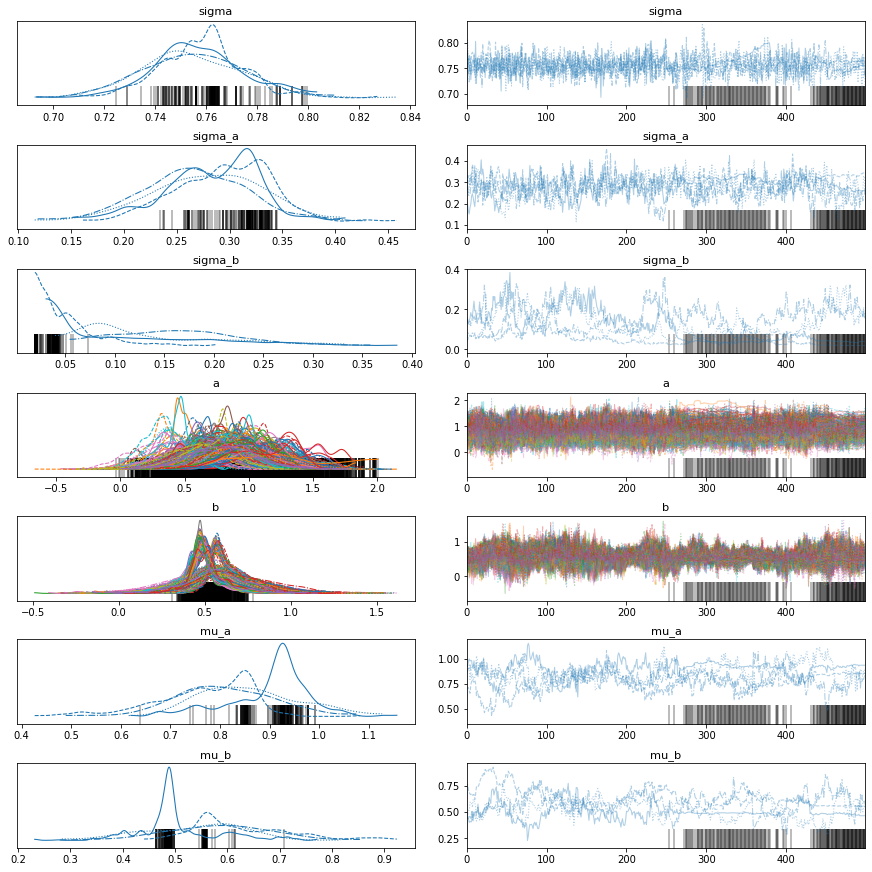

In [ ]:
# Posterior distributions and trace plots
az.plot_trace(fit2, legend = False, figsize=(12,12))

Diagnotic checks show that the sampling has NOT converged beacause of the parameterisation of the model. 

**Non-centered parameterisation should have been used in this case !**

Text(0.5, 1.0, 'Alpha')

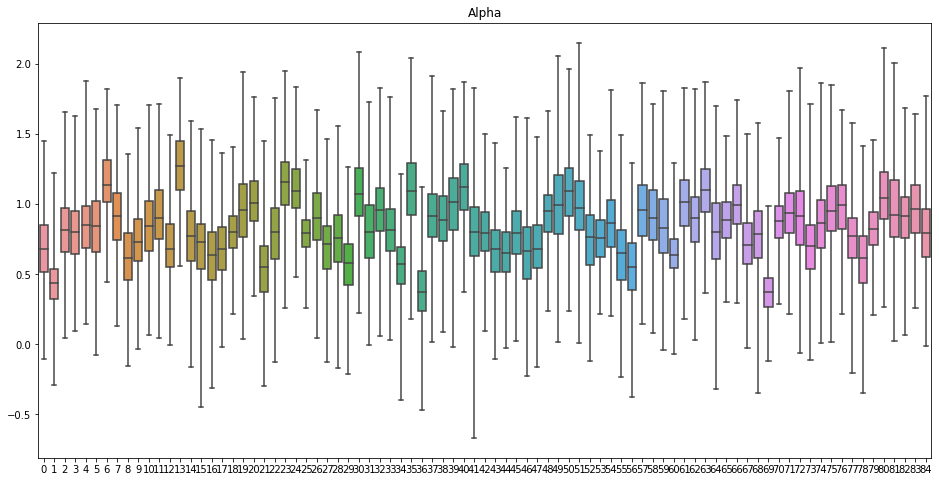

In [ ]:
# Boxplots
alpha = pd.DataFrame(fit2["a"])
beta = pd.DataFrame(fit2["b"])

plt.figure(figsize = (16,8))
sns.boxplot(data = alpha, whis = np.inf).set_title("Alpha")

Text(0.5, 1.0, 'Beta')

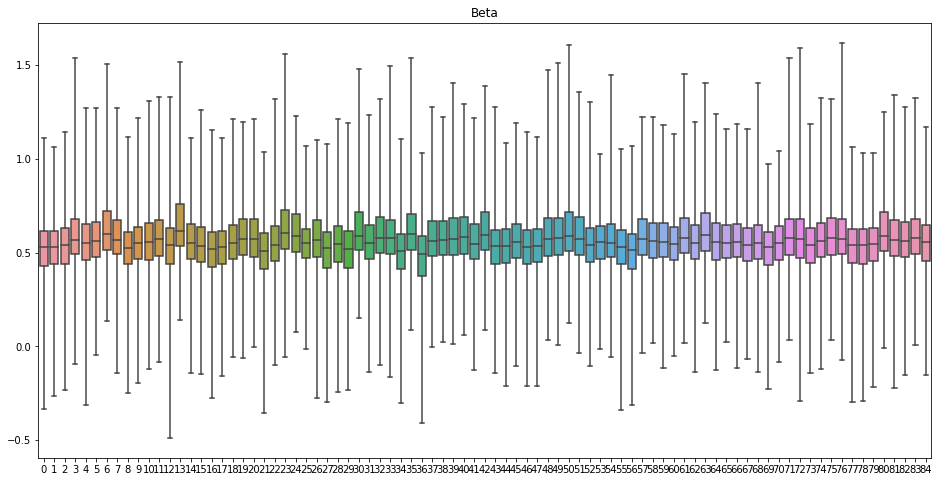

In [ ]:
plt.figure(figsize = (16,8))
sns.boxplot(data = beta, whis = np.inf).set_title("Beta")

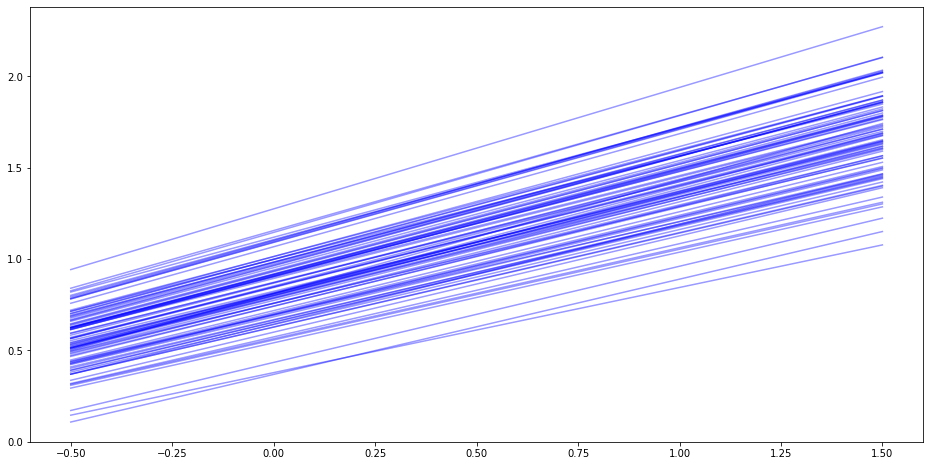

In [ ]:
# Plot regressions lines for each subgroup
alpha_mean = alpha.mean(axis=0)
beta_mean = beta.mean(axis = 0)

plt.figure(figsize = (16,8))
for alp, bet in zip(alpha_mean, beta_mean):
  y_hat = alp + bet * x_gen
  plt.plot(x_gen, y_hat, 'b-', alpha=0.4)